# Training WGAN to Generate Images (of Faces)

This Jupyter Notebook runs you through how this project can be used to train a Wasserstein Generative Adversarial Network (WGAN) to generate images of the same subject as the images in the data subdirectory of this project. In this case, I have trained the WGAN to generate images of faces (CelebA dataset; https://www.kaggle.com/datasets/jessicali9530/celeba-dataset). Since the training of GANs in general requires extensive hyperparameter tuning and continuous visual monitoring of the generated output, I prefer working with Notebooks over training from command line.

In [1]:
# IMPORT STATEMENTS
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

from wgan import *

In [2]:
##### HYPERPARAMETERS #####

image_input_dims = (64, 64, 3) # (img height, img width, color channels)
noise_dim = 1000 # latent space
k = 3 # number of times the discriminator is trained for every time the generator is trained
gradient_penalty_weight = 10.0
n = 16 # number of images generated during training for monitoring progress

# Note: it is important to give each model (model_name parameter) a distinctive name 
#(where & how model & progress are saved depend on it)
model_name = "WGAN"

In [3]:
# generate a set of random noise which we will keep consistent during training to better evaluate the progress
seed = tf.random.normal([n, noise_dim])

In [4]:
# MODEL ARCHITECTURE
# generator = initialize_generator(input_dims = image_input_dims,
#                                  noise_dim = noise_dim,
#                                  max_filters = 512, 
#                                  kernel_size = 5,
#                                  leaky_relu_slope = None, # if None, the model uses Parametric ReLU (PReLU)
#                                  model_name = 'generator')

# discriminator = initialize_discriminator(input_dims = image_input_dims,
#                                          noise_dim = noise_dim,
#                                          max_filters = 512, 
#                                          kernel_size = 5,
#                                          leaky_relu_slope = 0.2,
#                                          model_name = 'discriminator')

# or we can load previously trained models from file
generator = load_pretrained_model(file = model_name + "/generator.keras", folder = "trained_models")
discriminator = load_pretrained_model(file = model_name + "/discriminator.keras", folder = "trained_models")

generator.summary()
discriminator.summary()

Model: [generator] was successfully loaded!
Model: [discriminator] was successfully loaded!
Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 FC (Dense)                  (None, 8192)              8200192   
                                                                 
 BN (BatchNormalization)     (None, 8192)              32768     
                                                                 
 PReLu (PReLU)               (None, 8192)              8192      
                                                                 
 Reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 TConv2D_1 (Conv2DTranspose)  (None, 4, 4, 512)        6554112   
                                                                 
 BN_1 (BatchNormalization)   (None, 4, 4, 512)         2048      
                               

image batch shape: (64, 64, 64, 3)


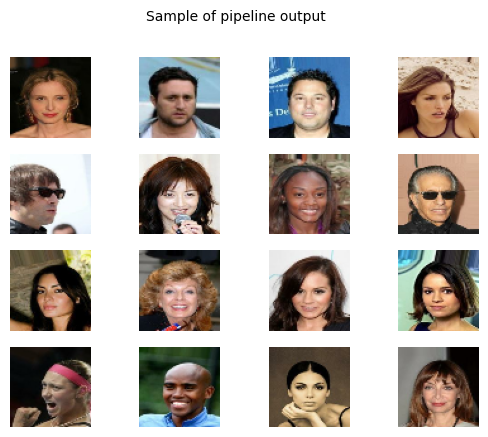

In [5]:
# CONFIGURE DATA PIPELINE
ds = config_data_input_pipeline(input_shape = image_input_dims, batch_size = 64, data_dir = "data")

In [6]:
# CREATE OVERALL WGAN MODEL
model = WGAN(discriminator = discriminator, 
             generator = generator,
             noise_dim = noise_dim, 
             k = k, # number of times the discriminator is trained for every time the generator is trained
             gp_weight = gradient_penalty_weight,
             model_name = model_name) 

In [7]:
# COMPILE MODEL
model.compile(dis_optimizer = Adam(learning_rate = 0.0002, beta_1 = 0.5), 
              gen_optimizer = Adam(learning_rate = 0.0002, beta_1 = 0.5))

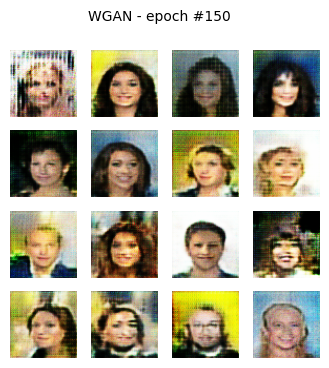

157/157 [==============================] - 29s 184ms/step - dis_loss: -10.1571 - gen_loss: -48.1321


In [21]:
# TRAIN THE MODEL
model.fit(ds, epochs = 150, callbacks = [monitor_wgan_performance(noise = seed, folder = 'training_progress')])

In [10]:
# SAVE MODEL
save_wgan_model(model = model, folder = "trained_models")

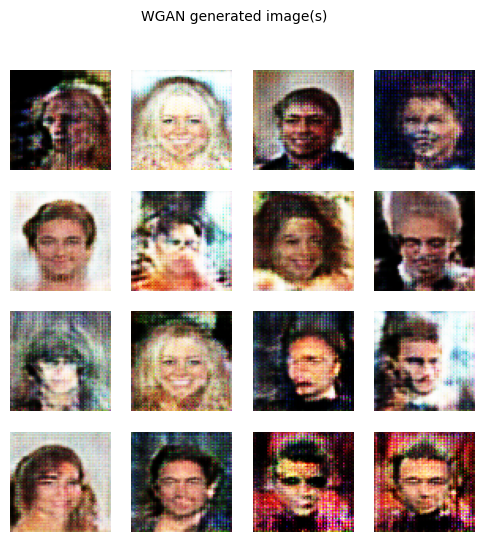

In [11]:
# GENERATE IMAGES
generated_imgs = wgan_generate(model = model, n = 16, figsize = (6, 6), title_fsize = 10, show = True)

In [12]:
# CREATE GIF OF TRAINING PROGRESS
create_gif(fname = model.name + '_training.gif', 
           train_progress_folder = 'training_progress/' + model.name, 
           loop = 30, duration = 180)

100%|███████████████████████████████████████████████████████████████████████████████| 151/151 [00:00<00:00, 392.60it/s]


## Considerations

The performance can be improved by:
- training the model longer
- increasing generator & discriminator architecture complexity (more layers, more filters, larger kernel sizes, etc.) 
- upping input resolution of the images
- introducing labels (conditional WGAN)

After 150 epochs of training the model is capable of producing blurry and noisy faces. One way of improving the output is by training and stacking an autoencoder on top of the WGAN to remove some of that blur and noise. 